In [1]:
# https://www.kaggle.com/lodetomasi1995/income-classification
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus
from io import StringIO
from sklearn.model_selection import cross_val_score, ShuffleSplit, GridSearchCV, validation_curve, learning_curve
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint as pp
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
import time
from sklearn.preprocessing import LabelEncoder

In [2]:
import warnings; warnings.simplefilter('ignore')

In [3]:
df = pd.read_csv("../../Data/income_evaluation.csv")
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
df = df.dropna()
df = df.ffill()
df = df.bfill()
df.shape
df.columns = list(map(lambda x: x.strip(), df.columns))

In [4]:
df.columns
price_range = df[['income']].to_numpy()
price_range[price_range=="<=50K"] = 0
price_range[price_range==">50K"] = 1
y_new = pd.DataFrame(price_range, columns=['income'])

In [23]:
# Do a one-hot encoding of string features - otherwise the predict method will fail
for i in df.columns:
    if i in ['workclass', 'education','marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']:
        df[i] = LabelEncoder().fit_transform(df[i])

In [24]:
X = df.drop(columns=['income'])
y = y_new
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
y_train = list(y_train['income'])
y_test = list(y_test['income'])

In [25]:
# Use min max scaling because input dataset is sparse, i.e. mostly zeros
scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [26]:
clf = MLPClassifier(random_state=1)
start_time = time.time()
clf.fit(x_train_scaled, y_train)
print(f"MLP Classifier Normal Model: Fit Time: {time.time() - start_time}")
start_time = time.time()
y_pred = clf.predict(x_test_scaled)
print(f"MLP Classifier Normal Model: Fit Time: {time.time() - start_time}")
print(f"Score of Model Tree are (Mean Accuracy of test and train data): {clf.score(x_test_scaled, y_test)}")

MLP Classifier Normal Model: Fit Time: 37.25278878211975
MLP Classifier Normal Model: Fit Time: 0.01466822624206543
Score of Model Tree are (Mean Accuracy of test and train data): 0.8409335175802242


[0.78762291 0.75994175 0.78036684 0.57537755 0.66543479 0.7810187
 0.78846788 0.6716919  0.77959944]
[0.00872593 0.03442192 0.00605475 0.26866613 0.19712446 0.01741127
 0.00871079 0.21536637 0.0155931 ]
[0.78742128 0.76052891 0.78198906 0.5753471  0.66233255 0.77902361
 0.78840975 0.6721607  0.77903294]
[0.00777281 0.03253765 0.00906835 0.26826651 0.19862595 0.0166063
 0.00812047 0.21572302 0.01478849]


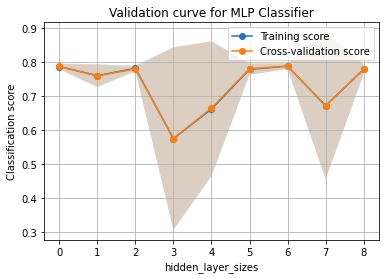

MLPClassifier(random_state=1)

In [32]:
# Initial Validation Curve
# Your MLP didn't converge: 
# The algorithm is optimizing by a stepwise convergence to a minimum and in run 1 your minimum wasn't found.
d = df.shape[1]
depth_range = [(h,)*l for l in [1,2,3] for h in [d,d//2,d*2]]

param = "hidden_layer_sizes"
classifier = "MLP Classifier"
train_scores, test_scores = validation_curve(clf, x_train, np.ravel(y_train), param_name=param, param_range=depth_range, cv=5)

mean_train_scores = np.mean(train_scores, axis=1)
std_train_scores = np.std(train_scores, axis=1)
mean_test_scores = np.mean(test_scores, axis=1)
std_test_scores = np.std(test_scores, axis=1)
depth_range_list = np.arange(0, len(depth_range), 1)
plt.figure()
plt.xticks(np.arange(0, len(depth_range)))
plt.plot(depth_range_list, mean_train_scores, 'o-', label='Training score')
plt.fill_between(depth_range_list, mean_train_scores - std_train_scores, mean_train_scores + std_train_scores, alpha=0.2)
plt.plot(depth_range_list, mean_test_scores, 'o-', label='Cross-validation score')
plt.fill_between(depth_range_list, mean_test_scores - std_test_scores, mean_test_scores + std_test_scores, alpha=0.2)
plt.title(f'Validation curve for {classifier}')
plt.xlabel(param)
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
#plt.savefig(fig_path + 'dt_validation_curve_1.png')
plt.show()

In [34]:
from sklearn.model_selection import cross_val_score
crossValScores = cross_val_score(clf, x_train, y_train, cv=5)
print("Cross Valuation Scores for unpruned tree are ", crossValScores)
print("Mean accuracy score is ", crossValScores.mean())
print("Std accuracy score is ", crossValScores.std())

Cross Valuation Scores for unpruned tree are  [0.79059501 0.79481766 0.79788868 0.76905356 0.29986562]
Mean accuracy score is  0.6904441043830459
Std accuracy score is  0.19555018783602268


In [35]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.91      0.90      4953
           1       0.69      0.61      0.65      1560

    accuracy                           0.84      6513
   macro avg       0.79      0.76      0.77      6513
weighted avg       0.84      0.84      0.84      6513



In [36]:
print(confusion_matrix(y_test, y_pred))

[[4519  434]
 [ 602  958]]


In [37]:
# To make the results deterministic - we need to use random_state
pipelineA = Pipeline([('scaler', StandardScaler()), 
                      ('mlp', MLPClassifier(random_state=1))])
start_time = time.time()
p = pipelineA.fit(x_train, y_train)
print(f"MLP Pipeline Model: Fit Time: {time.time() - start_time}")
start_time = time.time()
y_pred_pipelineA = p.predict(x_test)
print(f"MLP Pipeline Model: Predict Time: {time.time() - start_time}")

MLP Pipeline Model: Fit Time: 20.682520627975464
MLP Pipeline Model: Predict Time: 0.00936269760131836


In [38]:
d = x_train.shape[1]
param = { 
         'mlp__alpha': [0.065, 0.075, 0.08, 0.090],
         'mlp__hidden_layer_sizes': [(h,)*l for l in [1,2,3] for h in [d,d//2,d*2]],
         'mlp__activation': ['relu', 'logistic', 'tanh'],
         'mlp__solver': ['adam', 'sgd', 'lbfgs'], 
         'mlp__learning_rate': ['constant', 'invscaling', 'adaptive']
        }
clf_cv = GridSearchCV(pipelineA, n_jobs=-1, param_grid=param, refit=True, cv=5, return_train_score=True, verbose=10)
start_time = time.time()
clf_cv = clf_cv.fit(x_train, y_train)
print(f"DT CV Model: Fit Time: {time.time() - start_time}")
start_time = time.time()
y_pred_pipeline_cv = clf_cv.predict(x_test)
print(f"DT CV Model: Predict Time: {time.time() - start_time}")
clf_cv.best_params_

Fitting 5 folds for each of 972 candidates, totalling 4860 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 229 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 289 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done 353 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:  

DT CV Model: Fit Time: 536.8339936733246
DT CV Model: Predict Time: 0.007723093032836914


{'mlp__activation': 'logistic',
 'mlp__alpha': 0.09,
 'mlp__hidden_layer_sizes': (7, 7, 7),
 'mlp__learning_rate': 'constant',
 'mlp__solver': 'lbfgs'}

In [39]:
print(classification_report(y_test, y_pred_pipeline_cv))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90      4953
           1       0.72      0.59      0.65      1560

    accuracy                           0.85      6513
   macro avg       0.80      0.76      0.78      6513
weighted avg       0.84      0.85      0.84      6513



In [ ]:
sc_df = pd.DataFrame(clf_cv.cv_results_)
sc_df.dropna(inplace=True)
sc_df.sort_values(by="rank_test_score", ascending=True)

In [43]:
# Initial learning curve
train_sizes = np.arange(0.1, 1.0, 0.1)
cv_new = MLPClassifier(random_state=0, activation='lbfgs', alpha=0.09, hidden_layer_sizes= (7,7,7))
_, train_scores, test_scores = learning_curve(cv_new, x_train, y_train, train_sizes=train_sizes, cv=5)
learning_curve(cv_new, x_train, y_train, train_sizes=train_sizes, cv=5)

(array([ 2083,  4167,  6251,  8335, 10419, 12502, 14586, 16670, 18754]),
 array([[nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan]]),
 array([[nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan]]))

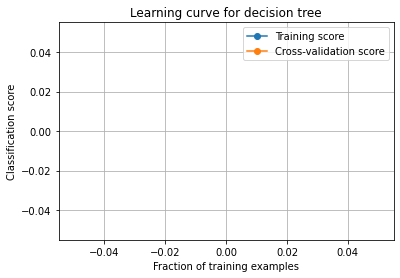

In [41]:
plt.figure()
mean_train_scores = np.mean(train_scores, axis=1)
std_train_scores = np.std(train_scores, axis=1)
mean_test_scores = np.mean(test_scores, axis=1)
std_test_scores = np.std(test_scores, axis=1)
plt.plot(train_sizes, mean_train_scores, 'o-', label='Training score')
plt.fill_between(train_sizes, mean_train_scores - std_train_scores, mean_train_scores + std_train_scores, alpha=0.2)
plt.plot(train_sizes, mean_test_scores, 'o-', label='Cross-validation score')
plt.fill_between(train_sizes, mean_test_scores - std_test_scores, mean_test_scores + std_test_scores, alpha=0.2)
plt.title('Learning curve for decision tree')
plt.xlabel('Fraction of training examples')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
#plt.savefig(fig_path + 'dt_learning_curve.png')
plt.show()

In [44]:
fit_time_list = []
predict_time_list = []
param = "hidden_layer_sizes"
param_list = [(h,)*l for l in [1,2,3,4,5] for h in [d,d//2,d*2]]
# y_train = list(y_train['income'])
clf_score_list = []
main_start_time = time.time()
for i in param_list:
    clf = MLPClassifier(hidden_layer_sizes=i)
    start_time = time.time()
    clf.fit(x_train_scaled, y_train)
    clf_score_list.append(clf.score(x_train_scaled, y_train))
    print(f"Clf score: {clf.score(x_train_scaled, y_train)}")
    end_time = time.time() - start_time
    fit_time_list.append(end_time)
#     print(f"DT Normal Model: Fit Time: {end_time}")
    
    start_time = time.time()
    y_pred = clf.predict(x_test_scaled)
    end_time = time.time() - start_time
    predict_time_list.append(end_time)
print(f"Entire cell took {time.time() - main_start_time}")
#     print(f"DT Normal Model: Predict Time: {end_time}")
    
#     print(f"Number of Nodes in the tree {clf.tree_.node_count}")
#     print("\n\n")

Clf score: 0.8561501842751843
Clf score: 0.8525798525798526
Clf score: 0.8586071867321867
Clf score: 0.858914312039312
Clf score: 0.8536931818181818
Clf score: 0.8685503685503686
Clf score: 0.8568796068796068
Clf score: 0.8572635135135135
Clf score: 0.8756142506142506
Clf score: 0.8604499385749386
Clf score: 0.8540770884520884
Clf score: 0.8834075552825553
Clf score: 0.8665540540540541
Clf score: 0.8581848894348895
Clf score: 0.8962684275184275
Entire cell took 202.6907253265381


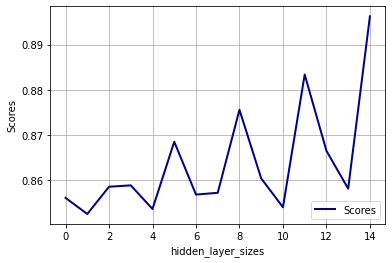

In [45]:
def normalize_data_points(points):
    return points
lw = 2
param_list = np.arange(0, len([(h,)*l for l in [1,2,3,4,5] for h in [d,d//2,d*2]]))
# plt.plot(param_list, normalize_data_points(fit_time_list), label="Fit time", color="darkred", lw=lw)
# plt.plot(param_list, normalize_data_points(predict_time_list), label="Predict Time", color="darkgreen", lw=lw)
plt.plot(param_list, normalize_data_points(clf_score_list), label="Scores", color="darkblue", lw=lw)
plt.xlabel(param)
plt.ylabel("Scores")
# plt.xticks(np.arange(1, len(fit_time_list), 1.0))
# plt.yticks(np.arange(min(predict_time_list), max(fit_time_list), 0.004))
plt.grid()
plt.legend(loc='lower right')

In [ ]:
[(h,)*l for l in [1,2,3] for h in [d,d//2,d*2]]

In [ ]:
[h*l for l in [1,2,3] for h in [d,d//2,d*2]]

In [ ]:
len(clf_score_list)

In [ ]:
[(h,)*l for l in [1,2,3,4] for h in [d,d//2,d*2]]